In [1]:
%matplotlib inline

import nltk
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud,STOPWORDS
import collections

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB

In [2]:
df = pd.read_csv('data/Tweets.csv')

In [3]:
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [6]:
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
AirlineStopwords = ['United', 'Virgin America', 'Delta', 'US Airways', 'Southwest', 'American', 'amp', 'plane', 'flight', 'JetBlue']
stopwords.extend(AirlineStopwords)

Text(0, 0.5, 'No. of Tweets')

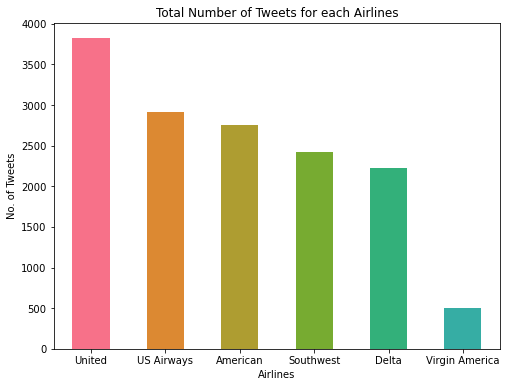

In [8]:
# Shows total number of tweets towards each airline
colors=sns.color_palette("husl", 10) 
pd.Series(df["airline"]).value_counts().plot(kind = "bar",
                        color=colors,figsize=(8,6),fontsize=10,rot = 0, title = "Total Number of Tweets for each Airlines")
plt.xlabel('Airlines', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

In [9]:
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:title={'center':'Total Tweets for Each Sentiment'}, ylabel='airline_sentiment'>

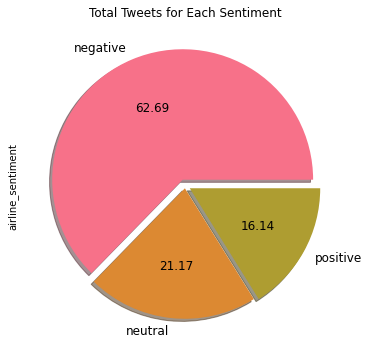

In [10]:
colors=sns.color_palette("husl", 10)
pd.Series(df["airline_sentiment"]).value_counts().plot(kind="pie",colors=colors,
    labels=["negative", "neutral", "positive"],explode=[0.05,0.02,0.04],
    shadow=True,autopct='%.2f', fontsize=12,figsize=(6, 6),title = "Total Tweets for Each Sentiment")

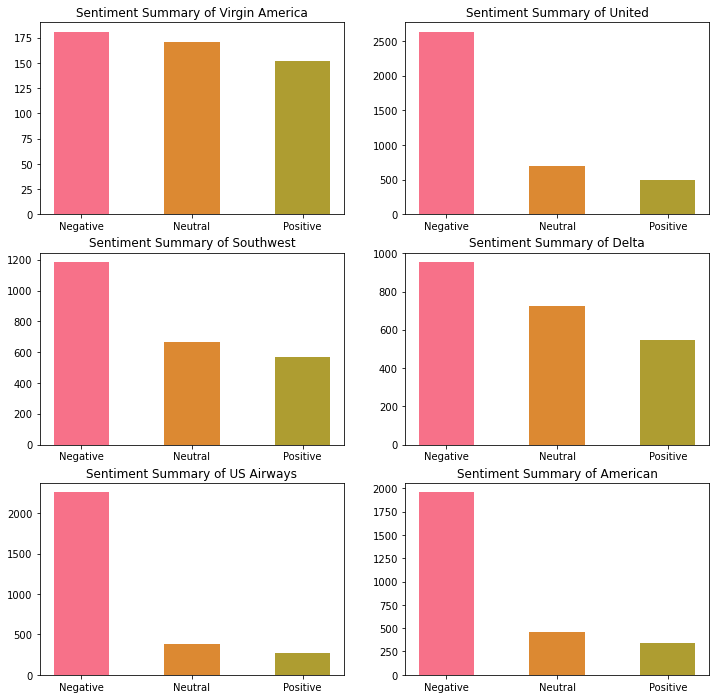

In [11]:
def plot_sub_sentiment(Airline):
    pdf = df[df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color=sns.color_palette("husl", 10)
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Sentiment Summary of' + " " + Airline)

airline_name = df['airline'].unique()
plt.figure(1,figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])

In [12]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

Text(0, 0.5, 'No. of Tweets')

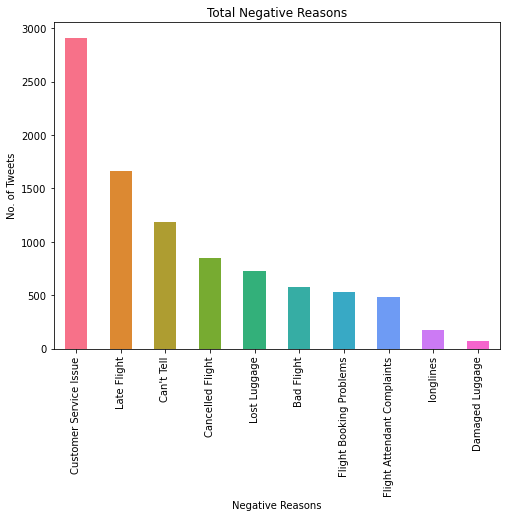

In [13]:
color=sns.color_palette("husl", 10)
pd.Series(df["negativereason"]).value_counts().plot(kind = "bar",
                        color=color,figsize=(8,6),title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

In [14]:
df.negativereason.value_counts().head(5)

Customer Service Issue    2910
Late Flight               1665
Can't Tell                1190
Cancelled Flight           847
Lost Luggage               724
Name: negativereason, dtype: int64

<AxesSubplot:title={'center':'Top 5 Negative Reasons'}, ylabel='negativereason'>

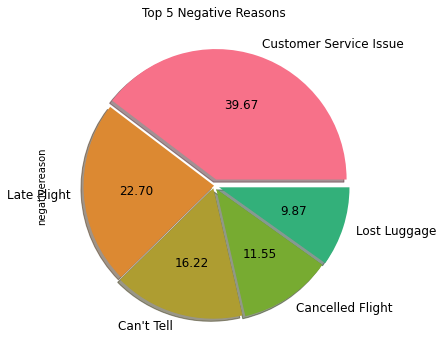

In [15]:
color=sns.color_palette("husl", 10)
pd.Series(df["negativereason"]).value_counts().head(5).plot(kind="pie",
                labels=["Customer Service Issue", "Late Flight", "Can't Tell","Cancelled Flight","Lost Luggage"],
                colors=color,autopct='%.2f',explode=[0.05,0,0.02,0.03,0.04],shadow=True,
                fontsize=12,figsize=(6, 6),title="Top 5 Negative Reasons")

In [16]:
air_sentiment = pd.crosstab(df.airline, df.airline_sentiment)
air_sentiment

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152

In [17]:
percent = air_sentiment.apply(lambda a: a / a.sum() * 100, axis=1)
percent

airline_sentiment   negative    neutral   positive
airline                                           
American           71.040232  16.781443  12.178325
Delta              42.979298  32.538254  24.482448
Southwest          49.008264  27.438017  23.553719
US Airways         77.686234  13.079300   9.234466
United             68.890633  18.236525  12.872841
Virgin America     35.912698  33.928571  30.158730

<AxesSubplot:title={'center':'Airline Sentiment'}, xlabel='airline'>

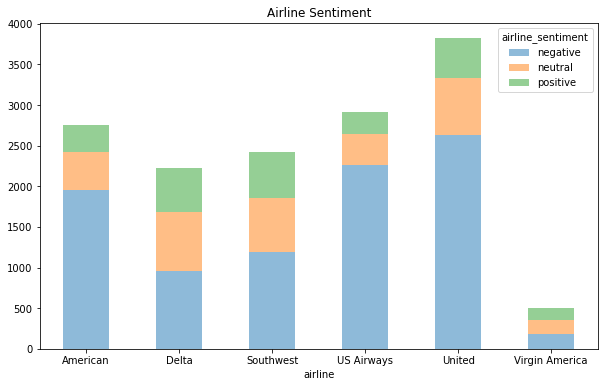

In [18]:
pd.crosstab(index = df["airline"],columns = df["airline_sentiment"]).plot(kind='bar',
                figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Airline Sentiment")

<AxesSubplot:title={'center':'Airline Sentiment Percentage'}, xlabel='airline'>

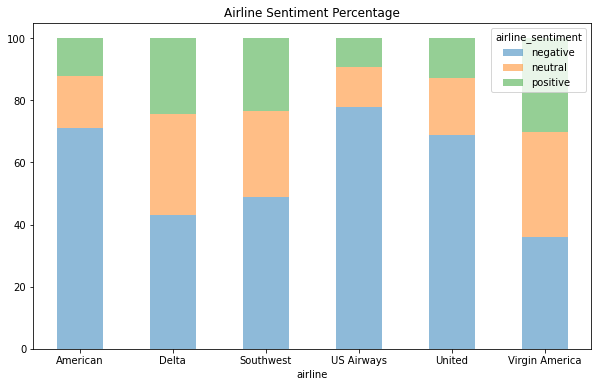

In [19]:
percent.plot(kind='bar',figsize=(10, 6),alpha=0.5,
                rot=0,stacked=True,title="Airline Sentiment Percentage")

In [20]:
#visualization using wordcloud for the negative tweets
cloud = df[df['airline_sentiment']=='negative']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [21]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

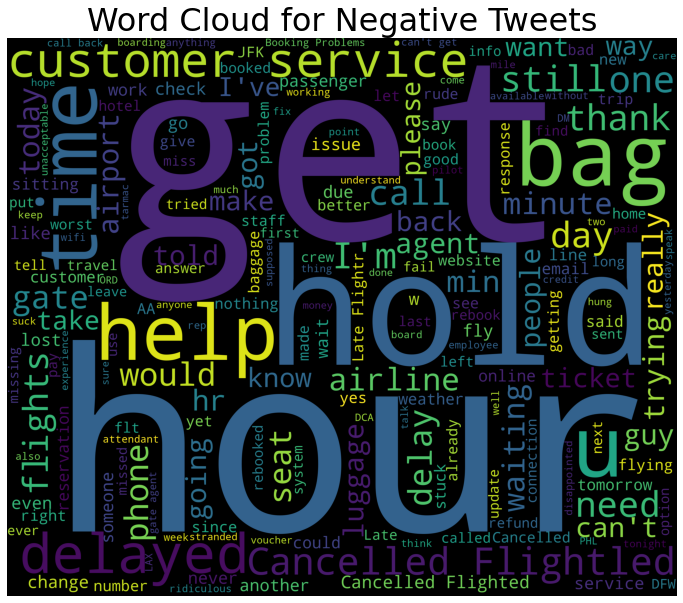

In [22]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Negative Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 3375
Word: get, count: 945
Word: Cancelled, count: 912
Word: customer, count: 533
Word: service, count: 520
Word: hold, count: 516
Word: 2, count: 513
Word: I'm, count: 486
Word: Flight, count: 474
Word: &amp;, count: 468
Word: hours, count: 467
Word: time, count: 411
Word: -, count: 400
Word: still, count: 395
Word: call, count: 384
Word: can't, count: 379
Word: Late, count: 374
Word: one, count: 371
Word: delayed, count: 358
Word: hour, count: 355
Word: would, count: 330
Word: us, count: 330
Word: Flightled, count: 318
Word: need, count: 314
Word: help, count: 311
Word: flights, count: 305
Word: gate, count: 303
Word: back, count: 300
Word: bag, count: 287
Word: waiting, count: 286


In [24]:
#visualization using wordcloud for the positive tweets
cloud = df[df['airline_sentiment']=='positive']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [25]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

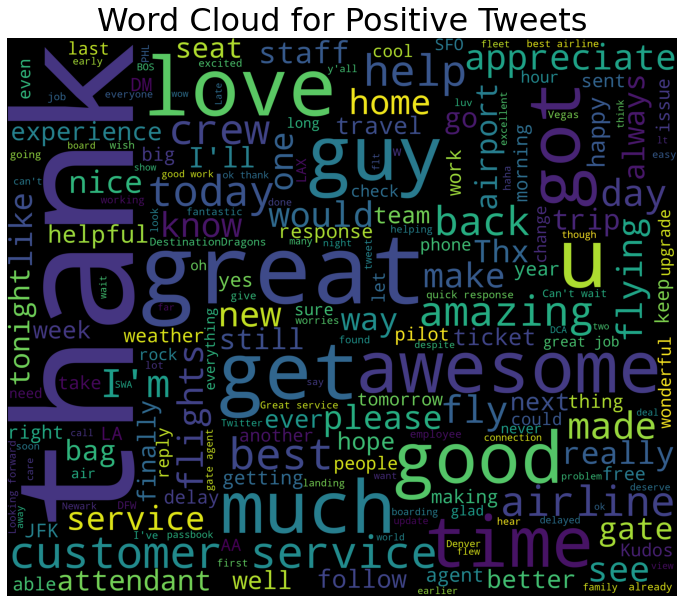

In [26]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Positive Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [27]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 574
Word: Thank, count: 231
Word: thanks, count: 218
Word: thank, count: 204
Word: Thanks, count: 177
Word: great, count: 144
Word: you!, count: 129
Word: get, count: 111
Word: customer, count: 101
Word: service, count: 100
Word: :), count: 96
Word: -, count: 87
Word: love, count: 85
Word: got, count: 85
Word: &amp;, count: 77
Word: you., count: 77
Word: guys, count: 76
Word: good, count: 75
Word: Thanks!, count: 69
Word: I'm, count: 67
Word: best, count: 63
Word: You, count: 62
Word: us, count: 62
Word: time, count: 59
Word: flying, count: 59
Word: like, count: 57
Word: would, count: 56
Word: made, count: 55
Word: fly, count: 54
Word: much, count: 54


In [28]:
df_delta = df[df['airline'] == 'Delta']

In [29]:
#visualization using wordcloud for the positive tweets
cloud = df_delta[df_delta['airline_sentiment']=='positive']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [30]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

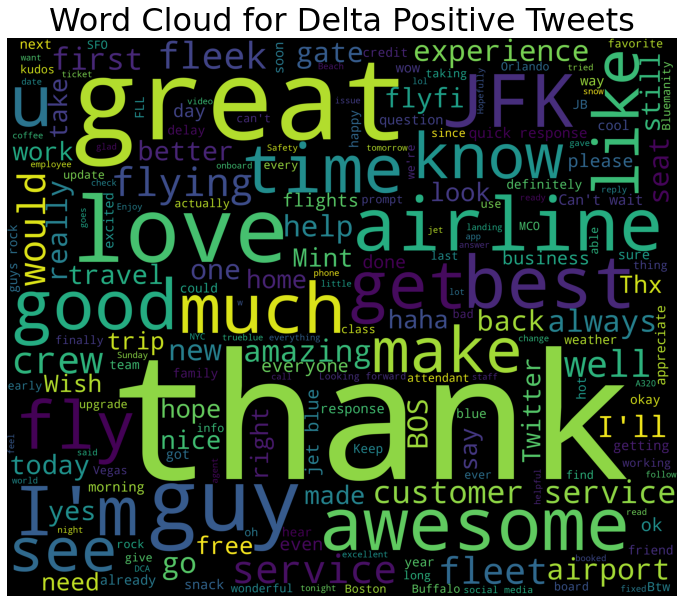

In [31]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Delta Positive Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [32]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 129
Word: thanks, count: 53
Word: thank, count: 44
Word: great, count: 37
Word: Thank, count: 37
Word: Thanks, count: 36
Word: :), count: 29
Word: you!, count: 28
Word: guys, count: 25
Word: love, count: 24
Word: I'm, count: 20
Word: fly, count: 19
Word: -, count: 19
Word: service, count: 17
Word: flying, count: 16
Word: see, count: 16
Word: Great, count: 16
Word: like, count: 16
Word: Our, count: 16
Word: “@JetBlue:, count: 15
Word: know, count: 15
Word: best, count: 15
Word: You, count: 15
Word: customer, count: 15
Word: would, count: 15
Word: &amp;, count: 15
Word: good, count: 14
Word: fleek., count: 14
Word: get, count: 14
Word: Thanks!, count: 14


In [33]:
cloud = df_delta[df_delta['airline_sentiment']=='negative']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [34]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

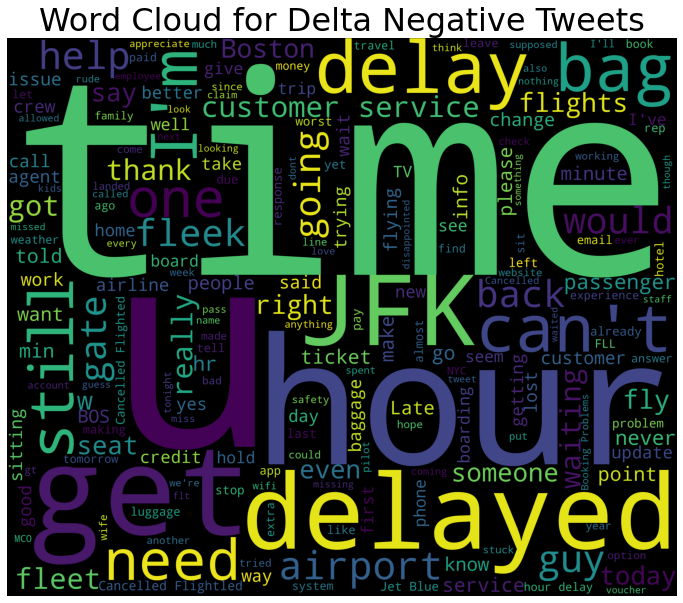

In [35]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Delta Negative Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [36]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 340
Word: get, count: 74
Word: 2, count: 56
Word: &amp;, count: 52
Word: Flight, count: 51
Word: delayed, count: 49
Word: us, count: 48
Word: Cancelled, count: 47
Word: I'm, count: 47
Word: can't, count: 44
Word: still, count: 43
Word: delay, count: 41
Word: service, count: 39
Word: hour, count: 38
Word: JFK, count: 38
Word: No, count: 38
Word: time, count: 37
Word: customer, count: 37
Word: hours, count: 36
Word: flight., count: 32
Word: Late, count: 31
Word: waiting, count: 31
Word: -, count: 31
Word: going, count: 30
Word: Our, count: 30
Word: fleet's, count: 29
Word: fleek., count: 29
Word: would, count: 28
Word: got, count: 28
Word: one, count: 28


In [37]:
df_southwest = df[df['airline'] == 'Southwest']

In [38]:
cloud = df_southwest[df_southwest['airline_sentiment']=='positive']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [39]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

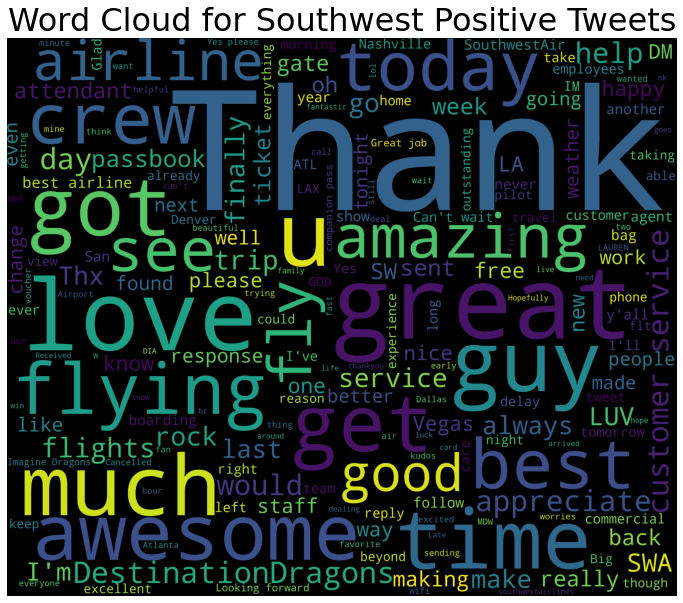

In [40]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Southwest Positive Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [41]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 149
Word: Thank, count: 71
Word: Thanks, count: 49
Word: thank, count: 38
Word: thanks, count: 38
Word: great, count: 34
Word: get, count: 30
Word: you!, count: 30
Word: love, count: 29
Word: you., count: 27
Word: got, count: 26
Word: guys, count: 24
Word: best, count: 22
Word: customer, count: 22
Word: service, count: 22
Word: -, count: 21
Word: flying, count: 20
Word: crew, count: 20
Word: fly, count: 18
Word: would, count: 18
Word: us, count: 17
Word: #DestinationDragons, count: 17
Word: much, count: 16
Word: see, count: 16
Word: Thanks!, count: 15
Word: I'm, count: 15
Word: appreciate, count: 15
Word: airline, count: 14
Word: last, count: 14
Word: :), count: 14


In [42]:
cloud = df_southwest[df_southwest['airline_sentiment']=='negative']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [43]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

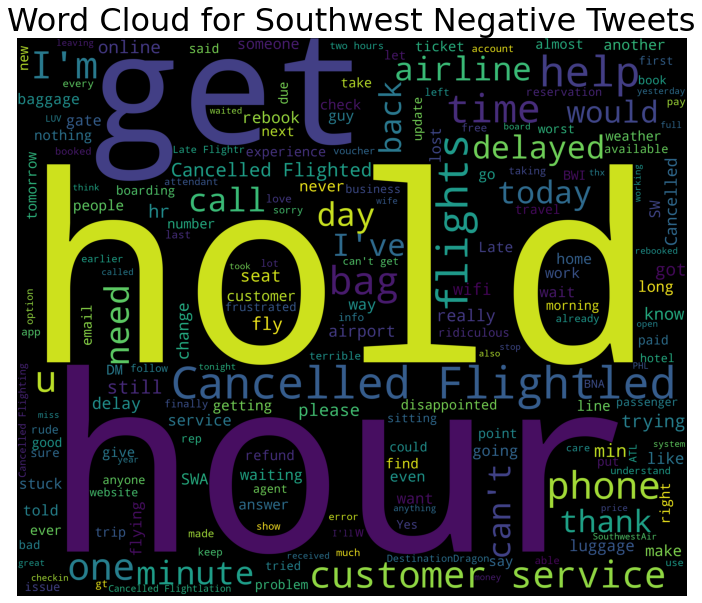

In [44]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Southwest Negative Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [45]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 449
Word: Cancelled, count: 201
Word: get, count: 134
Word: hold, count: 128
Word: 2, count: 85
Word: customer, count: 79
Word: hours, count: 73
Word: I'm, count: 68
Word: Flightled, count: 67
Word: Flight, count: 67
Word: flights, count: 66
Word: &amp;, count: 64
Word: service, count: 62
Word: one, count: 60
Word: can't, count: 56
Word: time, count: 55
Word: hour, count: 54
Word: -, count: 51
Word: got, count: 46
Word: I've, count: 43
Word: help, count: 43
Word: phone, count: 42
Word: need, count: 42
Word: call, count: 40
Word: Late, count: 40
Word: like, count: 38
Word: still, count: 37
Word: would, count: 37
Word: trying, count: 35
Word: minutes, count: 35


In [46]:
df_virginamerica = df[df['airline'] == 'Virgin America']

In [47]:
cloud = df_virginamerica[df_virginamerica['airline_sentiment']=='positive']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [48]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

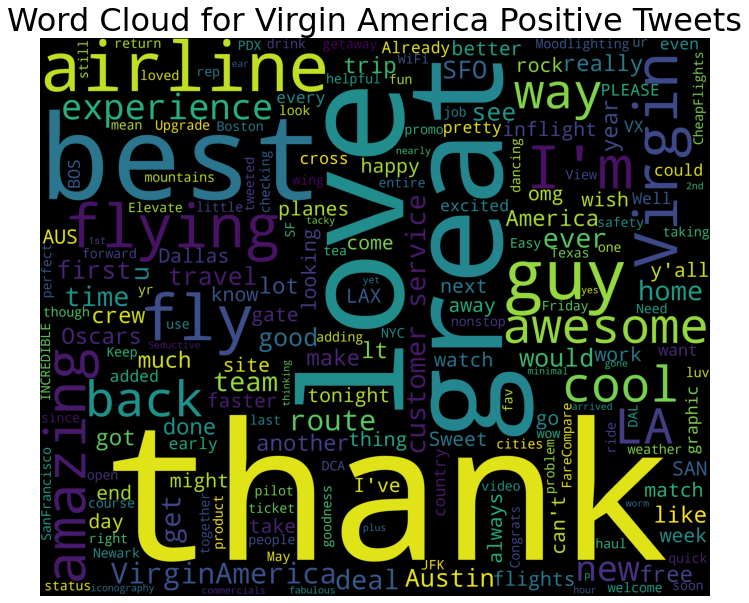

In [49]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Virgin America Positive Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [50]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 39
Word: great, count: 12
Word: love, count: 12
Word: I'm, count: 9
Word: thanks, count: 9
Word: fly, count: 8
Word: flying, count: 7
Word: airline, count: 7
Word: customer, count: 7
Word: thank, count: 7
Word: guys, count: 7
Word: :), count: 6
Word: &amp;, count: 6
Word: back, count: 6
Word: best, count: 6
Word: Thank, count: 6
Word: get, count: 6
Word: service, count: 6
Word: Thanks!, count: 5
Word: first, count: 5
Word: way, count: 5
Word: -, count: 5
Word: cool, count: 5
Word: home, count: 5
Word: awesome, count: 5
Word: Thanks, count: 5
Word: Just, count: 5
Word: time, count: 4
Word: good, count: 4
Word: &lt;3, count: 4


In [51]:
cloud = df_virginamerica[df_virginamerica['airline_sentiment']=='negative']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [52]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

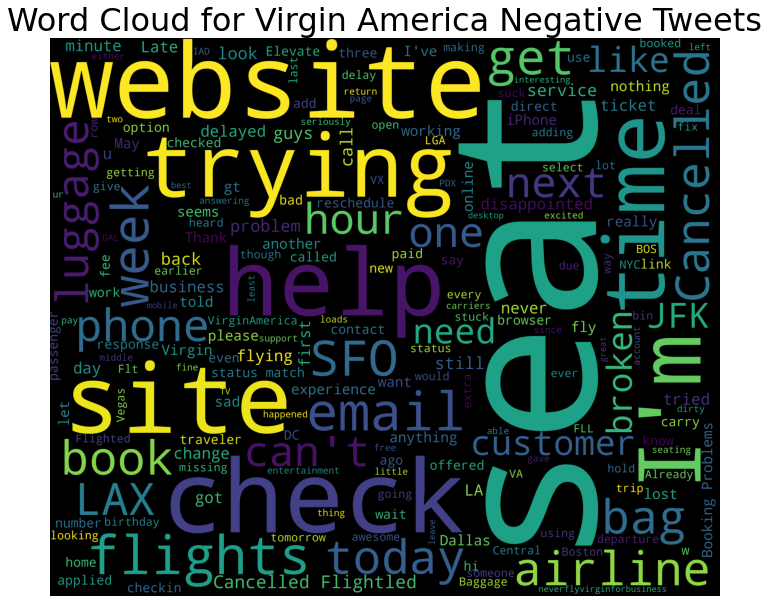

In [53]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for Virgin America Negative Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [54]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 75
Word: Cancelled, count: 18
Word: website, count: 17
Word: Flight, count: 16
Word: check, count: 14
Word: site, count: 13
Word: I'm, count: 13
Word: flights, count: 13
Word: trying, count: 12
Word: seat, count: 11
Word: -, count: 10
Word: book, count: 10
Word: get, count: 9
Word: 2, count: 8
Word: next, count: 8
Word: can't, count: 8
Word: Your, count: 8
Word: like, count: 8
Word: email, count: 8
Word: &amp;, count: 7
Word: guys, count: 7
Word: one, count: 6
Word: time, count: 6
Word: bag, count: 6
Word: Late, count: 6
Word: back, count: 6
Word: Just, count: 6
Word: luggage, count: 6
Word: You, count: 6
Word: JFK, count: 6


In [55]:
df_united = df[df['airline'] == 'United']

In [56]:
cloud = df_united[df_united['airline_sentiment']=='negative']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [57]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

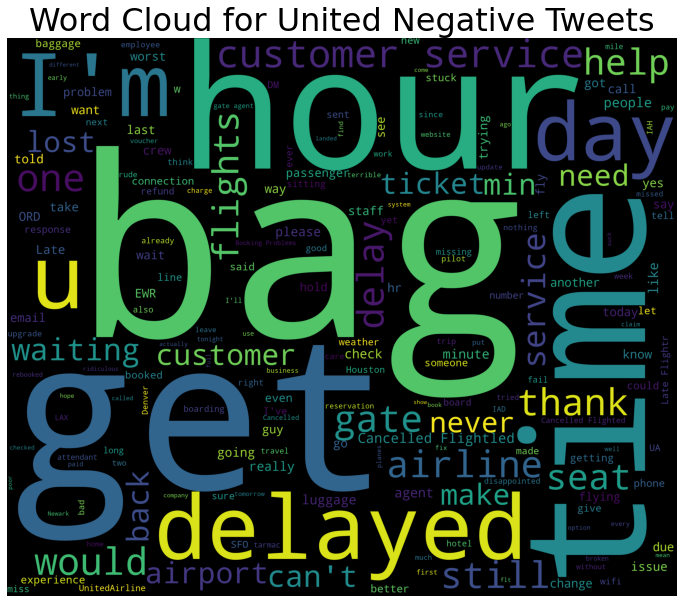

In [58]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for United Negative Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [59]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 908
Word: get, count: 233
Word: Cancelled, count: 170
Word: service, count: 161
Word: I'm, count: 160
Word: customer, count: 159
Word: time, count: 144
Word: -, count: 134
Word: delayed, count: 129
Word: &amp;, count: 128
Word: would, count: 127
Word: Late, count: 123
Word: Flight, count: 123
Word: bag, count: 115
Word: still, count: 112
Word: one, count: 107
Word: hours, count: 105
Word: gate, count: 105
Word: like, count: 96
Word: hour, count: 95
Word: 2, count: 94
Word: can't, count: 86
Word: waiting, count: 85
Word: flights, count: 83
Word: us, count: 82
Word: 3, count: 79
Word: help, count: 75
Word: last, count: 72
Word: lost, count: 70
Word: You, count: 69


In [60]:
cloud = df_united[df_united['airline_sentiment']=='positive']
words = ' '.join(cloud['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word
                                and not word.startswith('@') and word != 'RT'])

In [61]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=3000, height=2500
                     ).generate(cleaned_word)

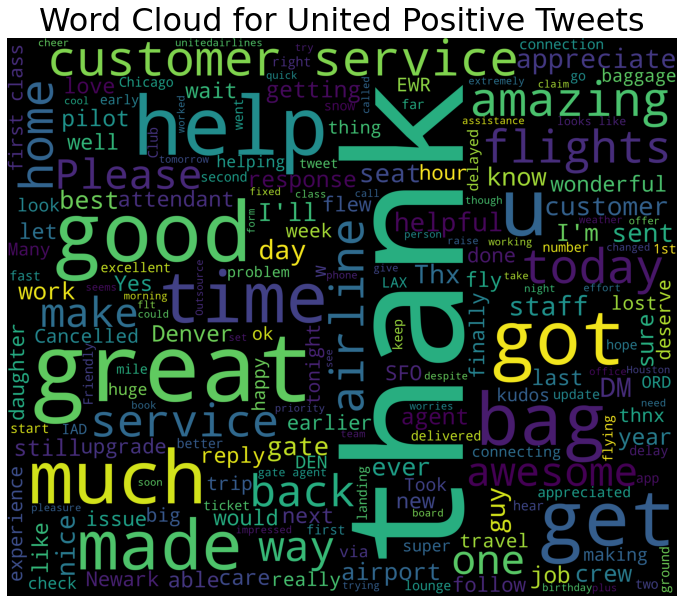

In [62]:
plt.figure(1,figsize=(12, 12))
plt.title('Word Cloud for United Positive Tweets', fontdict={'fontsize': 32})
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [63]:
filtered_words_spam = [word for word in cleaned_word.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(30):
    word_count_spam[letter] = count
    
for i,j in word_count_spam.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: I, count: 113
Word: thank, count: 53
Word: Thank, count: 50
Word: thanks, count: 42
Word: Thanks, count: 42
Word: you!, count: 34
Word: :), count: 26
Word: customer, count: 25
Word: great, count: 24
Word: get, count: 24
Word: good, count: 21
Word: service, count: 20
Word: got, count: 20
Word: &amp;, count: 19
Word: made, count: 17
Word: You, count: 15
Word: you., count: 15
Word: Thanks!, count: 15
Word: -, count: 14
Word: flights, count: 14
Word: us, count: 14
Word: like, count: 14
Word: gate, count: 13
Word: time, count: 13
Word: bag, count: 12
Word: make, count: 12
Word: I'll, count: 12
Word: first, count: 12
Word: back, count: 12
Word: much, count: 12


In [64]:
def reason_each_flight(airline):
    data = df[df['airline'] == airline]
    data = data['negativereason']
    data_count = data.value_counts()
    List = data.value_counts().index.tolist()
    Index = range(1,(len(data.unique())))
    plt.bar(Index, data_count)
    plt.xlabel('Negative Words')
    plt.ylabel('Total Number of Tweets')
    plt.title('Total number of Negative Tweets for ' + airline)
    plt.xticks(Index, List,rotation = 90)

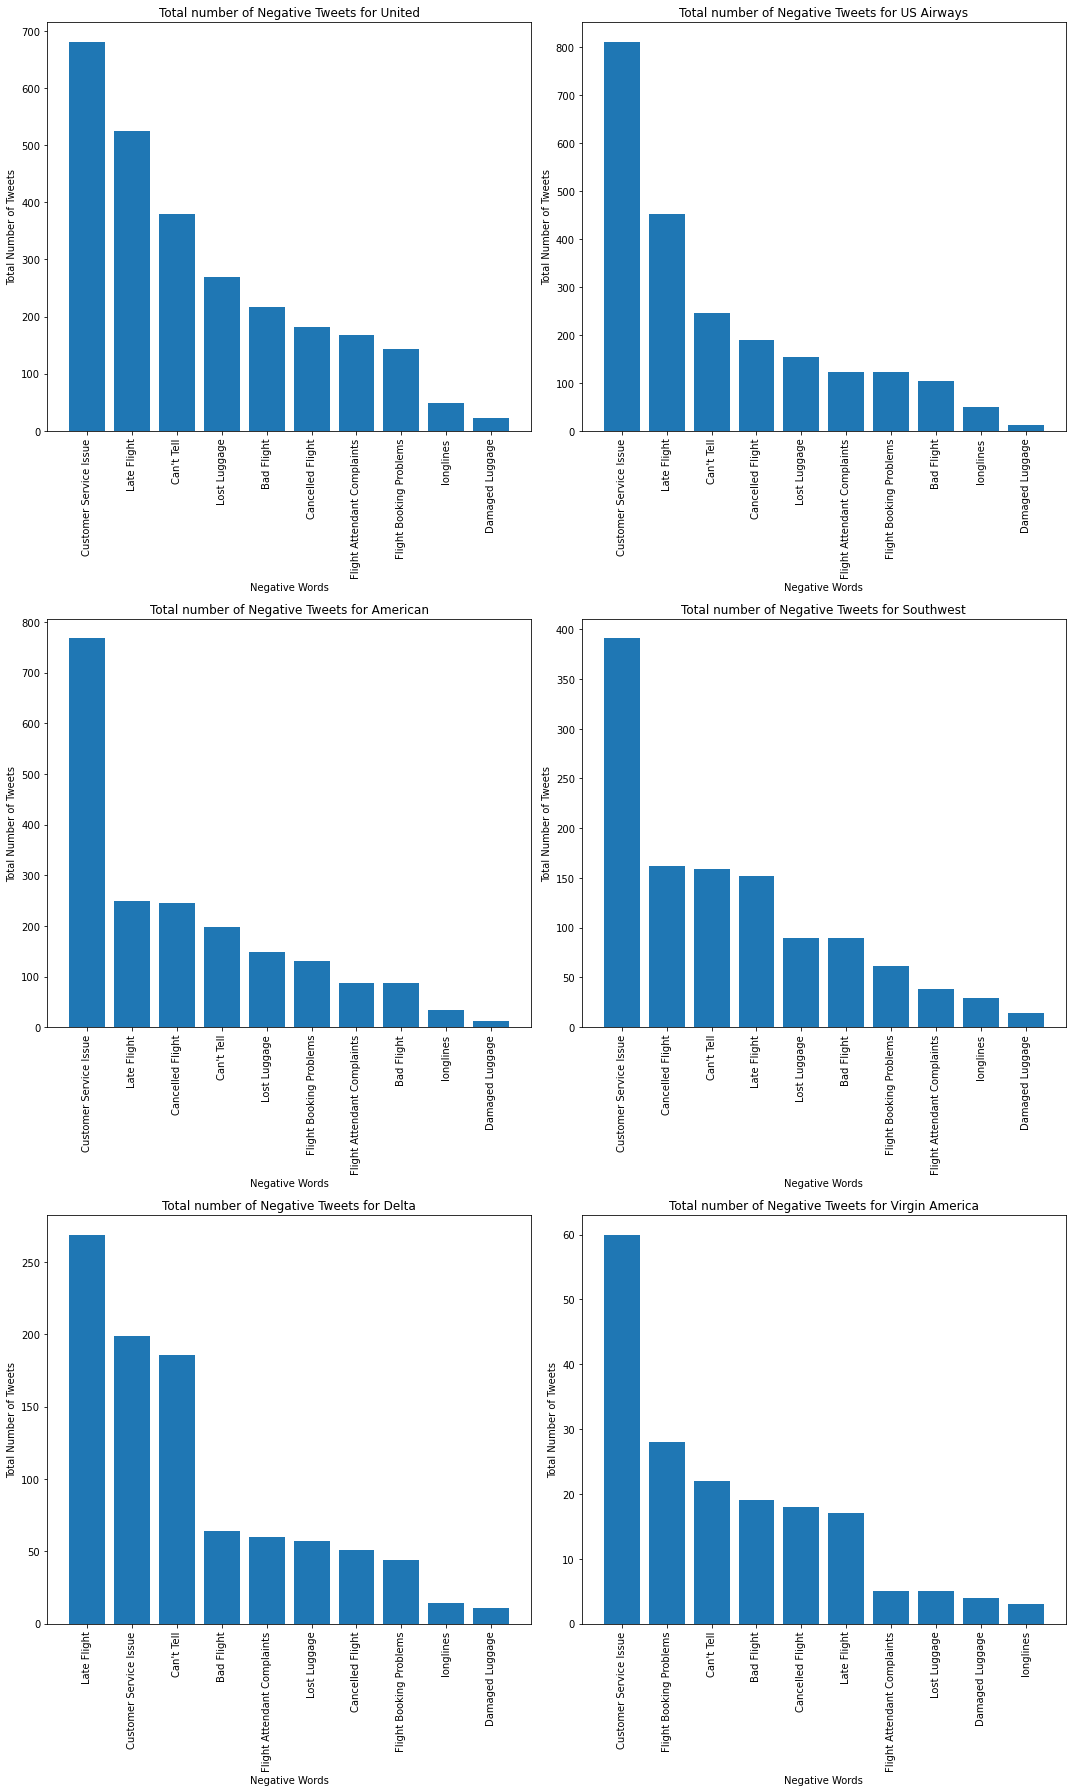

In [65]:
Air = df['airline'].value_counts().index.tolist()
plt.figure(1,figsize=(15, 25))
plt.subplot(321)
reason_each_flight(Air[0])
plt.subplot(322)
reason_each_flight(Air[1])
plt.subplot(323)
reason_each_flight(Air[2])
plt.subplot(324)
reason_each_flight(Air[3])
plt.subplot(325)
reason_each_flight(Air[4])
plt.subplot(326)
reason_each_flight(Air[5])
plt.tight_layout()